# Keyframe Detection

#### Sean Reddy
#### October 26, 2017

The problem revolves around identifying keyframes and clustering scenes together that correspond to these keyframes. Our general process is going to be:

1) Feature Extraction: Convert images into a format that we can compare frames to one another

2) Clustering: Apply clustering on the transformed image features

3) Keyframe Detection: Identify the point in the frame sequence in which the scenes change and select the first instance of a new scene as the keyframe for that scene

4) Presentation: Match the cluster assignment to the frame and output in .csv format

##### See development system/build specs below.

In [1]:
import sys
print(sys.version)

2.7.12 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


### Import necessary libraries

In [2]:
import cv2
import os

import matplotlib.pyplot as plt

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

import pandas as pd
import string

from skimage.feature import hog
from skimage import data, color, exposure

### Feature Extraction

In [3]:
def extract_features_from_image(file, features_only=True, scaling_factor=0.2):

    """
    Extracts HoG features from an image in a given directory (after scaling)

    Inputs:
    - file: A directory to an image file in an accepted format by opencv

    Returns:
    - fd: A numpy array of features extracted from the image
    - img_gs: The original image in grayscale
    - hog_image: An image of the HoG feature representation of the input image
    """

    img = cv2.imread(file)
    
    if scaling_factor == 1.0:
        img_r = img
    elif scaling_factor > 1:
        img_r = cv2.resize(img, None, fx = scaling_factor, fy = scaling_factor, interpolation = cv2.INTER_CUBIC)
    else:
        img_r = cv2.resize(img, None, fx = scaling_factor, fy = scaling_factor, interpolation = cv2.INTER_AREA)

    img_gs = color.rgb2gray(img_r)
    fd, hog_image = hog(img_gs, orientations=16, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualise=True)

    if features_only:
        return(fd)
    else:
        return(img_gs, hog_image, fd)

##### Auxilliary functions for directory handling and image plotting

In [4]:
imageDir = os.getcwd() + '/Sequence1/'

def create_full_fp(imageName, dir=imageDir):
    image_path = dir + imageName
    return(image_path)

In [5]:
def plot_img_and_hog(image, hog_image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    ax2.axis('off')
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()

//anaconda/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


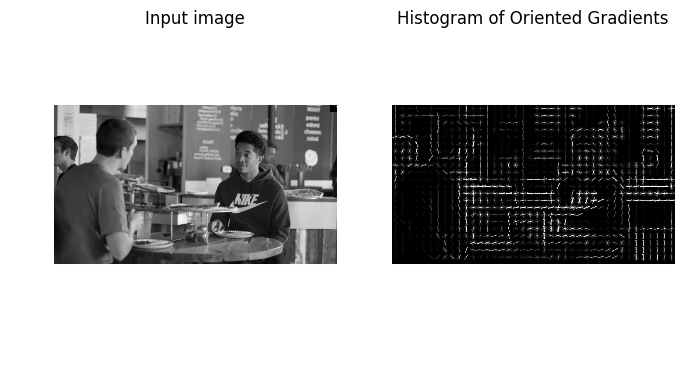

In [6]:
image, hog_image, fd = extract_features_from_image(imageDir + '000062.jpg', features_only=False, scaling_factor=1.0)
plot_img_and_hog(image, hog_image)

As we can see in the plot above, we are able to represent our images in a way that is much more easily comparable  (from a machine's perspective) frame by frame. We have transformed the original data into the HoG feature space in order to more broadly decipher differences between frames, ignoring small changes like minor character motion.

Let's now create a list of all of our images and then apply our feature extraction function to all of them.

In [ ]:
images = map(create_full_fp, os.listdir(imageDir))
feats = map(extract_features_from_image, images)

Working with numpy arrays is easier, so let's now convert to the more appropriate format and we'll see that we have a matrix with n rows and d dimensions with each dimension representing some HoG feature in that particular image.

In [ ]:
features = np.asarray(feats)
features.shape

### Clustering

We can now cluster our frames based on these features using **DBScan.**

I chose DBScan because one of the major concerns of this problem with regards to clustering is that we have no idea how many different scenes exist within the collection of images. As such, we cannot naively use something like K-means clustering (as we don't know K).

The parameter 'eps' indicates the radius of the "bubble" around a given data point to find other nearby datapoints (in this case in euclidean space). With some knowledge of the variable and a few test cases below, we are able to define this hyperparameter as we see fit. It may be worth looking into using a different space to define distance as well, perhaps something like cosine similarity.

We use eps=1.0 for scaled-down images (20% of original size at 64x128) and eps=11.5 for full-fidelity images at 320x640 (distances below are at the full-fidelity and roughly how we estimated on eps=11.5, the maximum margin between known different scenes and known similar scenes).

The parameter 'min_samples' indicates the number of samples required in order to be considered a 'cluster' rather than noise (perhaps filtering out something like single-frame subliminal messages or single frames of postprocessing fading between scenes). The data points outside of clusters will be classified as noise (label = -1).

In [39]:
dist = np.linalg.norm(features[2]-features[60])
dist2 = np.linalg.norm(features[2]-features[62])
print("Dist between a known Same Angle from First to Last Frame: ", dist)
print("Different Angle: ", dist2)

('Dist between a known Same Angle from First to Last Frame: ', 8.0763671839859104)
('Different Angle: ', 15.169069415132721)


In [40]:
db = DBSCAN(eps=1, min_samples=3).fit(features)
labels = db.labels_

Let's take a look at what our results are per frame in order of appearance (frame number).

In [41]:
labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4,

We see that there are a few repeat scenes, but for the most part the frames are sequentially the same as the ones near them as we would expect (many frames per scene). Now let's figure out the keyframes.

### Keyframe Detection

In [42]:
keyframe_ind = [labels[i] != labels[i-1] for i, val  in enumerate(labels)]
keyframe_idxs = [i for i, val in enumerate(keyframe_ind) if val==True]
keyframe_filenames = ["%06d" % (i+1) + ".jpg" for i, val in enumerate(keyframe_ind) if val==True]

Let's look at our keyframes and respective indices:

In [43]:
keyframe_filenames

['000001.jpg',
 '000003.jpg',
 '000062.jpg',
 '000103.jpg',
 '000163.jpg',
 '000221.jpg',
 '000277.jpg',
 '000323.jpg',
 '000371.jpg',
 '000398.jpg',
 '000449.jpg',
 '000478.jpg',
 '000569.jpg',
 '000652.jpg',
 '000747.jpg']

In [44]:
keyframe_idxs

[0, 2, 61, 102, 162, 220, 276, 322, 370, 397, 448, 477, 568, 651, 746]

In [45]:
keyframe_scenes = labels[keyframe_idxs]

Now that we know which keyframes to look for, we need to attach the cluster assignment to these keyframes to determine which scene/camera angle they belong to. Let's collect these and assign them alphabetically A-Z and arrange them in a dataframe.

### Presentation

In [46]:
keyframe_scenes

array([0, 1, 2, 3, 4, 5, 4, 5, 6, 7, 5, 4, 8, 0, 9])

In [47]:
import string
keyframe_scenes_ascii = [string.ascii_lowercase[i] for i in keyframe_scenes]

In [48]:
keyframe_scenes_ascii

['a', 'b', 'c', 'd', 'e', 'f', 'e', 'f', 'g', 'h', 'f', 'e', 'i', 'a', 'j']

In [49]:
result = pd.DataFrame([keyframe_filenames, keyframe_scenes_ascii]).transpose()

In [50]:
result.columns = ['keyframe', 'scene id']

In [51]:
result

,keyframe,scene id
0,000001.jpg,a
1,000003.jpg,b
2,000062.jpg,c
3,000103.jpg,d
4,000163.jpg,e
5,000221.jpg,f
6,000277.jpg,e
7,000323.jpg,f
8,000371.jpg,g
9,000398.jpg,h


After a bit of spot-checking, these scene assignments and keyframes seem to align with the image set. Let's save this output. Let's create a function that combines the prior steps of defining the keyframes once you have the cluster assignments. We can use this going forward as we don't need many of the intermediate results.

##### Let's see how we did:

We can use the below function to plot some of our keyframes alongside the images next to them to spot check our results.

In [140]:
def check_surrounding_frames_of_keyframe(l_key_im, key_im, r_key_im, i):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(l_key_im[i], cmap=plt.cm.gray)
    ax1.set_title('Left of Keyframe ' + str(i) + ' Image')

    ax2.axis('off')
    ax2.imshow(key_im[i], cmap=plt.cm.gray)
    ax2.set_title('Keyframe ' + str(i) + ' Image')

    ax3.axis('off')
    ax3.imshow(r_key_im[i], cmap=plt.cm.gray)
    ax3.set_title('Right of Keyframe ' + str(i) + ' Image')

    plt.show()

We just need to index the images of the surrounding keyframes

In [141]:
keyframe_filenames = [images[i] for i in keyframe_idxs]
left_keyframe_filenames = [images[i-1] for i in keyframe_idxs if i > 0]
right_keyframe_filenames =[images[i+1] for i in keyframe_idxs if i < len(labels)]

print(len(left_keyframe_filenames), len(keyframe_filenames), len(right_keyframe_filenames))

(14, 15, 15)


Note there is no left frame if the first keyframe is the first frame (which it always is). We fix this, as well as the same problem on the latter end, after we pull in the images themselves.

In [142]:
key_im = map(cv2.imread, keyframe_filenames)
l_key_im = map(cv2.imread, left_keyframe_filenames)
r_key_im = map(cv2.imread, right_keyframe_filenames)

In [143]:
if keyframe_idxs[0] == 0:
    left_keyframe_filenames = [None] + left_keyframe_filenames
    l_key_im = [None] + l_key_im
    
if keyframe_idxs[-1] == len(labels)-1:
    right_keyframe_filenames += [None]
    r_key_im += [None]

In [144]:
print(len(left_keyframe_filenames), len(keyframe_filenames), len(right_keyframe_filenames))

(15, 15, 15)


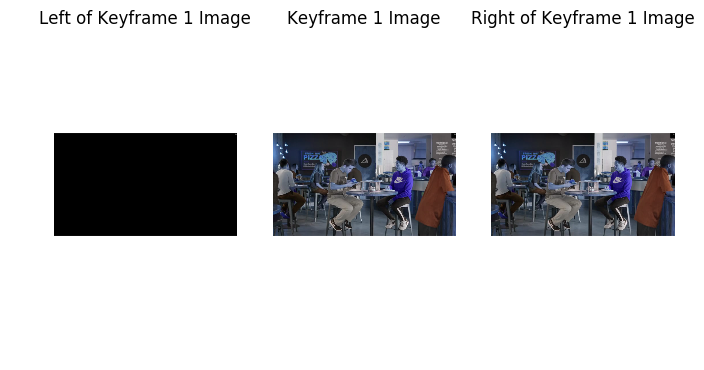

In [145]:
check_surrounding_frames_of_keyframe(l_key_im, key_im, r_key_im, 1)

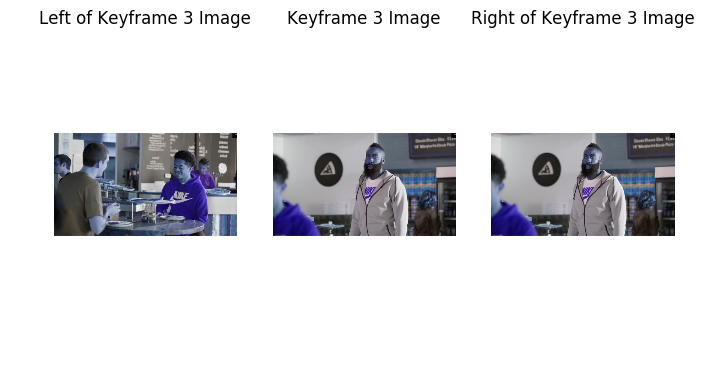

In [146]:
check_surrounding_frames_of_keyframe(l_key_im, key_im, r_key_im, 3)

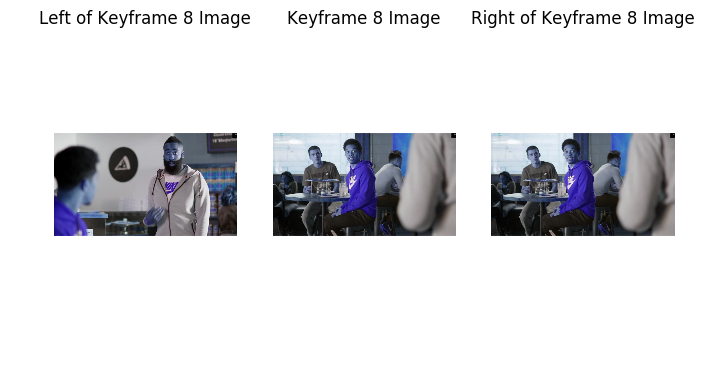

In [147]:
check_surrounding_frames_of_keyframe(l_key_im, key_im, r_key_im, 8)

It should be clear that the left keyframe images are different than the keyframe images (and remain the same on the right assuming the new scene is >1 frame in length). This indicates we are appropriately capturing at least SOME of the keyframes.

Let's now generate our csv report of our findings:

In [148]:
def create_output_csv(labels, filename):
    
    """
    Takes clustering results and creates a results dataframe and outputs a .csv file in the current directory.

    Inputs:
    - labels: A numpy array of labels assigned to frames (in chronological order).
    - filename: The name of the .csv file to be saved

    Returns:
    - None
    """
    
    keyframe_ind = [labels[i] != labels[i-1] for i, val  in enumerate(labels)]
    keyframe_idxs = [i for i, val in enumerate(keyframe_ind) if val==True]
    keyframe_filenames = ["%06d" % (i+1) + ".jpg" for i, val in enumerate(keyframe_ind) if val==True]
    keyframe_scenes = labels[keyframe_idxs]
    keyframe_scenes_ascii = [string.ascii_lowercase[i] for i in keyframe_scenes]
    result = pd.DataFrame([keyframe_filenames, keyframe_scenes_ascii]).transpose()
    result.columns = ['keyframe', 'scene id']
    filepath = os.getcwd()
    result.to_csv(filepath + '/' + filename)

In [55]:
create_output_csv(labels, 'Sequence1.csv')

**Voila.** We now have a pipeline that we can apply to any stream of images generated from frames of a video.

### Potential Future Improvements and Exploration

#### Explore other distance measures
    
    * Something like Cosine Similarity may be a better measure of these scene features' "closeness" than euclidean distance due to things like the curse of dimensionality
    * IMPORTANT: Euclidean distance is inherently not scale-invariant for the number of dimensions, so if your image size changes, you will have to readjust the hyperparameters of the DBScan. For scalability, this is pretty bad -- this would be my very first change, time permitting.

#### Try rescaling input images differently

    * We likely don't need the fidelity of the full image to decipher between scenes, we use the 20% of the original size images for this notebook to decrease computation time.
    * Computation time for the DBScan currently takes awhile, as does loading the images into memory. Fewer features generated assist with this problem.
    * We would have to adjust the 16x16 "pixels_per_cell" parameter when we are extracting the HoG features if we reduce this to a thumbnail (16x16 pixels_per_cell would only produce 4 cells for a 32x32 thumbnail, this is very likely insufficient)
   
   
#### Explore other image features

    * Things like SIFT features may work better in some cases than HoG features. HoG features were chosen due to their relative ease of interpretation while still retaining performance in differentiating frames.
   
    
#### Explore other hierarchical clustering methods

    * Something like OPTICS might be faster/better at clustering the feature representations of these frames
    
#### Test several other hyperparameters

    * We can adjust the 'eps' on the DBScan as well as 'min_samples' to see if perhaps some other combination of these hyperparameters yields better results. Some testing was already done heuristically on these hyperparameters but there is absolutely room for optimization.
    
    
#### Parallelize the feature extraction

    * We can speed up the total time it takes to load images into memory and generate the HoG features through parallelizing this process. Currently we are loading in each image into memory one-by-one rather than threading this process.